definition of working folder

In [43]:
Dirname <- "/working/R"
Dirs <- list.dirs(path=file.path("~"),recursive=T)
dir_wd <- names(unlist(sapply(Dirs,grep,pattern=Dirname))[1])
dir_wd <- paste(dir_wd,'appunti/dati',sep='/')
setwd(dir_wd)
cat("Current working folder is ' : ", getwd())

Current working folder is ' :  C:/Users/t004314/Documents/git/working/R/appunti/dati

# Time Series

## Euribor

In [44]:
require(zoo)

# import del file contenente i dati relativi all'indice S&P MIB
file_name = paste(getwd(),'hist_euribor.csv',sep='/')

euribor <- read.csv(file_name, sep=';')
euribor$Date = as.Date(euribor$Date)

# serie giornaliere
euribor1M = zoo(x=euribor$X1.Month, order.by=euribor$Date) 
euribor6M = zoo(x=euribor$X6.Month, order.by=euribor$Date) 
euribor1Y = zoo(x=euribor$X12.Month, order.by=euribor$Date) 


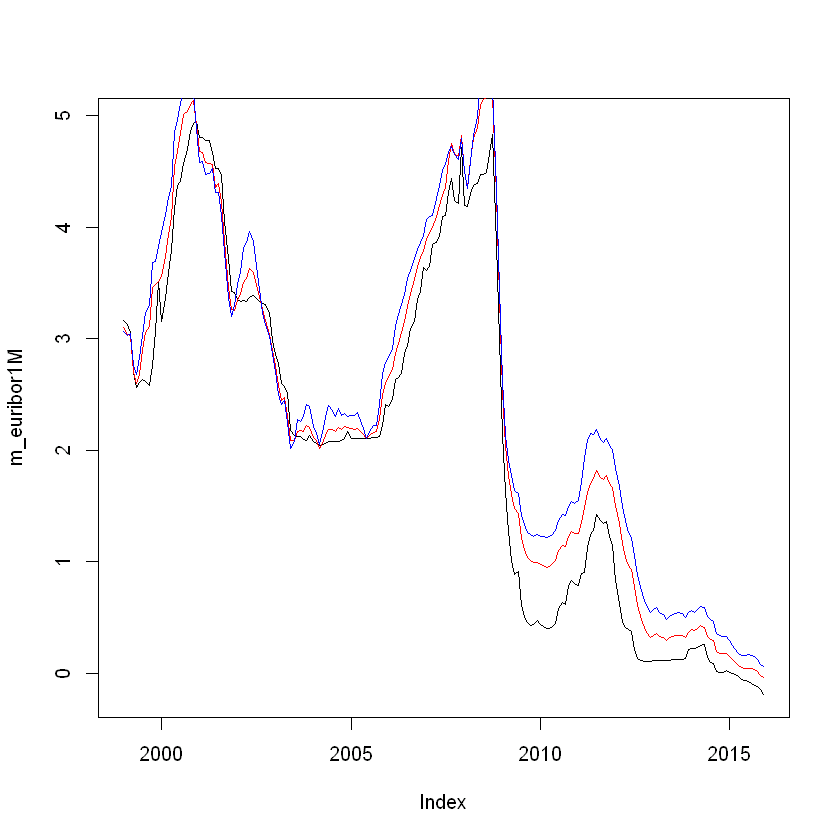

In [63]:
# creo un nuovo indice aggregando per mese-anno le date presenti originariamente
m_index      <- as.Date(as.yearmon(time(euribor1Y)))
# creo una nuova serie aggregando i dati di euribor1M sul nuovo indice temporale
# (base mensile) e calcolando la media
m_euribor1M  <- aggregate(euribor1M, m_index, mean)
m_euribor6M  <- aggregate(euribor6M, m_index, mean)
m_euribor1Y  <- aggregate(euribor1Y, m_index, mean)

plot (m_euribor1M, typ='l')
lines(m_euribor6M, col='red')
lines(m_euribor1Y, col='blue')

## Average deposit rate from Bankit database

In [64]:
file_name = paste(getwd(), 'tassi_medi_cc_bankit.csv', sep="/")
tassi <- read.csv(file_name, sep=';')

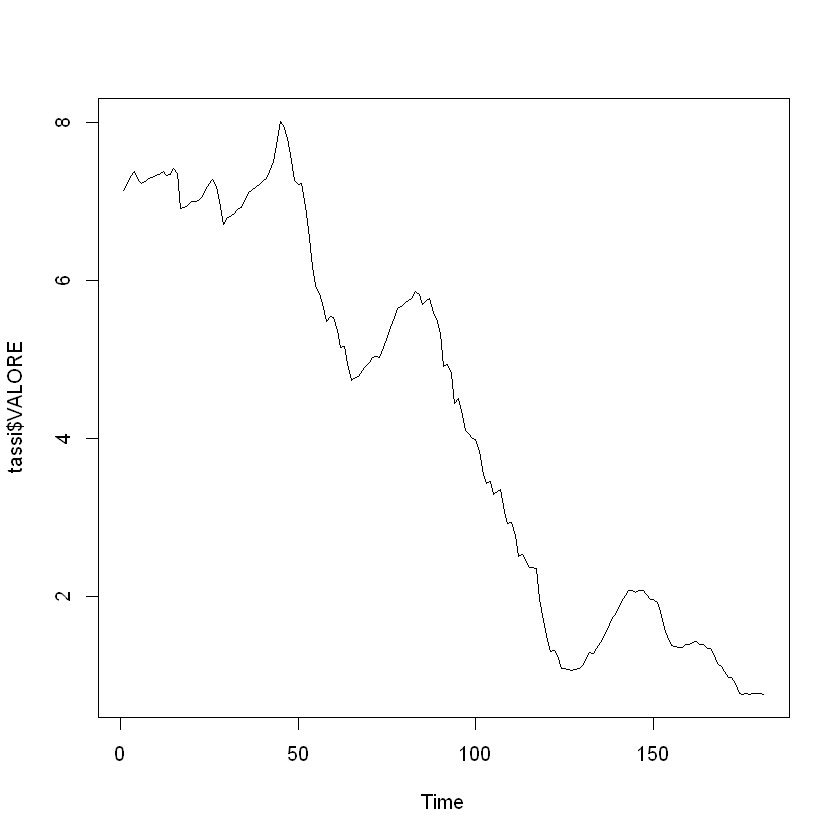

In [65]:
plot.ts(tassi$VALORE)

The file 'confronto.csv' was generated by taking the overlap period between the two time series of rates, mean value of the Italian banking system and the 1-month Euribor rate. The overlapping range is from January 1999 to December 2004. The series have a monthly frequency.

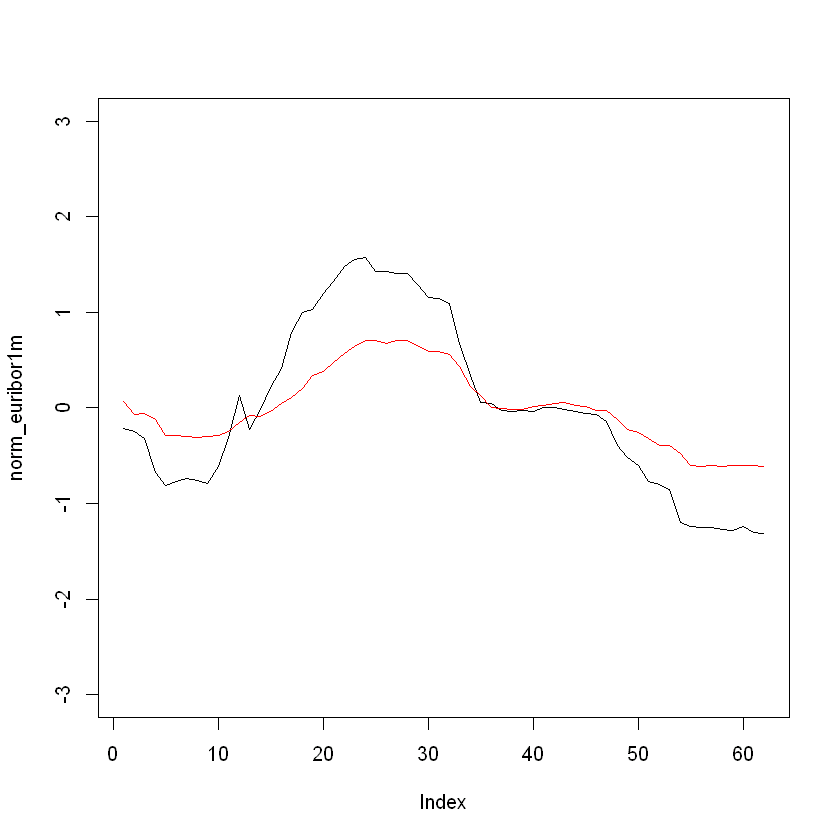

In [66]:
file_name = paste(getwd(), 'confronto.csv', sep="/")
tassi <- read.csv(file_name, sep=';')

norm_euribor1m <- tassi$EURIBOR1M-mean(tassi$EURIBOR1M)
norm_bank_rate <- tassi$TASSO_BANCA-mean(tassi$TASSO_BANCA)

plot(norm_euribor1m, type = 'l',ylim=c(-3,3))
lines(norm_bank_rate,col='red')

In [67]:
cor(norm_euribor1m, norm_bank_rate)
ccf(norm_euribor1m, norm_bank_rate,lag.max=5, plot=FALSE)

[1] 0.9756003


Autocorrelations of series 'X', by lag

   -5    -4    -3    -2    -1     0     1     2     3     4     5 
0.776 0.846 0.902 0.944 0.973 0.976 0.921 0.855 0.776 0.689 0.594 

## Example 1.9 Moving Averages and Filtering

Considering a white noise $w_t$, in this example we replace this noise with an average of its current value and its immediate neighbors in the past and future, that is
$$ v_t=\frac{1}{3}(w_{t-1} + w_t + w_{t+1})$$
A linear combination of values in a time series is referred generically, to as a filtered series, hence we use the command "filter"

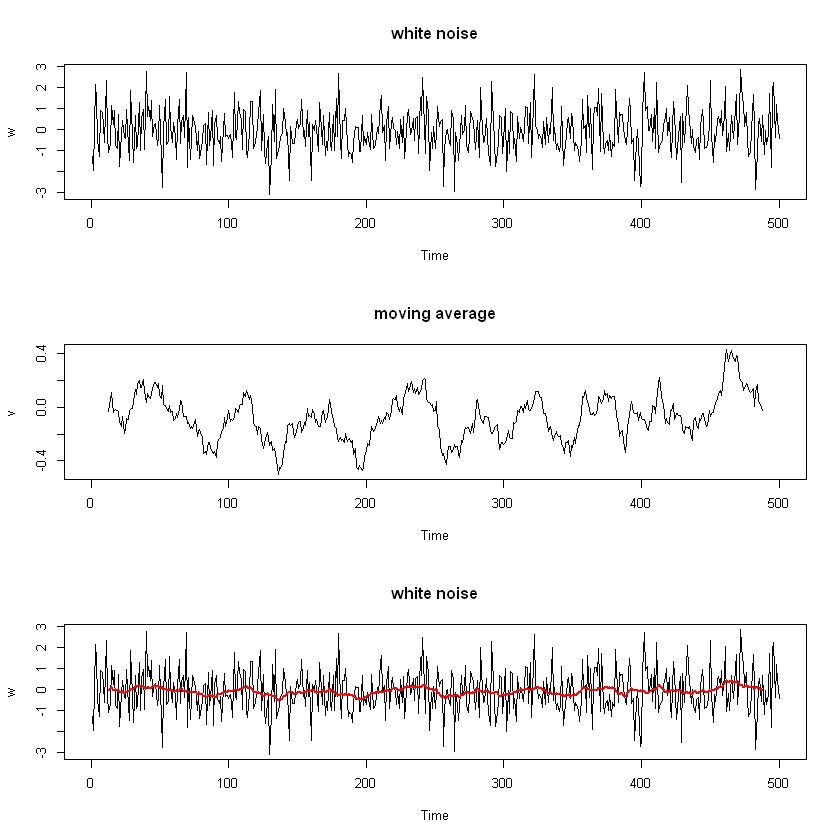

In [68]:
npoints = 500
size    = 25

w=rnorm(npoints)
v=filter(w,sides=2,filter=rep(1/size,size))

par(mfrow=c(3,1))
plot.ts(w, main='white noise')
plot.ts(v, main='moving average')
plot.ts(w, main='white noise')
lines(v, col='red', lwd=2)

### Autocovariance

The autocovariance function is defined as the second moment product

\begin{equation}
 \gamma (s,t) = cov(x_s,x_t) = E[(x_s-\mu_s)(x_t-\mu_t)]
\end{equation}

The white noise series $w_t$ has $\mathbb{E}(w_t)=0$ and 
$$
\gamma_w(t,s)= cov(w_s, w_t) = \begin{cases} \sigma^2_w & s=t, \\ 0 & s \ne t
\end{cases}
$$

In order to test this result we'll use the function shift which produce a shifted vector of a predefined amount.

In [51]:
shift<-function(x,shift_by){
  stopifnot(is.numeric(shift_by))
  stopifnot(is.numeric(x))
  
  if (length(shift_by)>1)
    return(sapply(shift_by,shift, x=x))
  
  out<-NULL
  abs_shift_by=abs(shift_by)
  if (shift_by > 0 )
    out<-c(tail(x,-abs_shift_by),rep(NA,abs_shift_by))
  else if (shift_by < 0 )
    out<-c(rep(NA,abs_shift_by), head(x,-abs_shift_by))
  else
    out<-x
  out
}

For example let's produce a shifted series of the white noise. Note that, in order to avoid NA points, we have to take only $n - 1$ points where $n$ is the original length of the $w$ series.

In [52]:
n  = length(w)
ww = shift(w, 1)[1:n-1]
w  = w[1:n-1] 

cat('covariance of w(t,t+1) = ',  cov(w,ww), "\n")

covariance of w(t,t+1) =  -0.03442975 


Let's compute the autocovariance of the moving average process. 
The process is described by the filter

$$ v_t=\frac{1}{3}(w_{t-1} + w_t + w_{t+1})$$

Then

$$\gamma(s,t)=cov \left[ \frac{1}{3}(w_{s-1} + w_s + w_{s+1}), \frac{1}{3}(w_{t-1} + w_t + w_{t+1})  \right]$$

We can summarize the values for all $s$ and $t$ for the $v$ process as:

$$
\gamma_v(s,t)= \begin{cases}
\frac{3}{9} \sigma^2_w & s=t, \\
\frac{2}{9} \sigma^2_w & \vert s - t \vert = 1, \\
\frac{1}{9} \sigma^2_w & \vert s - t \vert = 2, \\
0                      & \vert s - t \vert > 2 \\
\end{cases}
$$

Let's try to test these results

In [53]:
v = v[3:length(v)-1]

#cat('variance of v        = ',  var(w), "\n")
cat('covariance of v(t,t) = ',  cov(v,v), "\n")
cat('3*sigma^2 / 9        = ',  3*var(w)/9, "\n")


covariance of v(t,t) =  NA 
3*sigma^2 / 9        =  0.3436362 


In [54]:
n  = length(v)
vv = shift(v,1)
vv = vv[1:n-1]
v  = v[1:n-1]

cat('covariance of v(t,t+1) = ',  cov(v,vv), "\n")
cat('2*sigma^2 / 9          = ',  2*var(w)/9, "\n")


covariance of v(t,t+1) =  NA 
2*sigma^2 / 9          =  0.2290908 


In [55]:
n  = length(v)
vv = shift(vv,1)
vv = vv[1:n-1]
v  = v[1:n-1]

cat('covariance of v(t,t+2) = ',  cov(v,vv), "\n")
cat('1*sigma^2 / 9          = ',  1*var(w)/9, "\n")


covariance of v(t,t+2) =  NA 
1*sigma^2 / 9          =  0.1145454 


In [56]:
n  = length(v)
vv = shift(vv,1)
vv = vv[1:n-1]
v  = v[1:n-1]

cat('covariance of v(t,t+3) = ',  cov(v,vv), "\n")

covariance of v(t,t+3) =  NA 


### The autocorrelation function

The autocorrelation function (ACF) is defined as

$$
\rho(s,t) = \frac{\gamma(s,t)}{\sqrt{\gamma(s,s)\gamma(t,t)}}
$$

For the three-point moving average process we have:

$$
\rho_v(h)= \begin{cases}
1 & h=0, \\
\frac{2}{3} & \vert h\vert = 1, \\
\frac{1}{3} & \vert h\vert = 2, \\
0           & \vert h\vert > 2 \\
\end{cases}
$$


In [57]:
#v = v[3: length(v)-1]
acf(v, lag.max=10, plot=FALSE)
ccf(v,v, lag.max=10)

ERROR: Error in na.fail.default(as.ts(x)): missing values in object


ERROR: Error in na.fail.default(as.ts(x)): missing values in object


## Example 1.10 Autoregression

Suppose we consider the white noise of the previous example as input and calculate the output using the second-order equation
$$x_t=x_{t-1} -.9 x_{t-2}+w_t $$
This equation represents a regression or prediction of the current value of $x_t$ of a time series as a function of the past two values of the series and, hence, the term 'autoregression' is used for this model

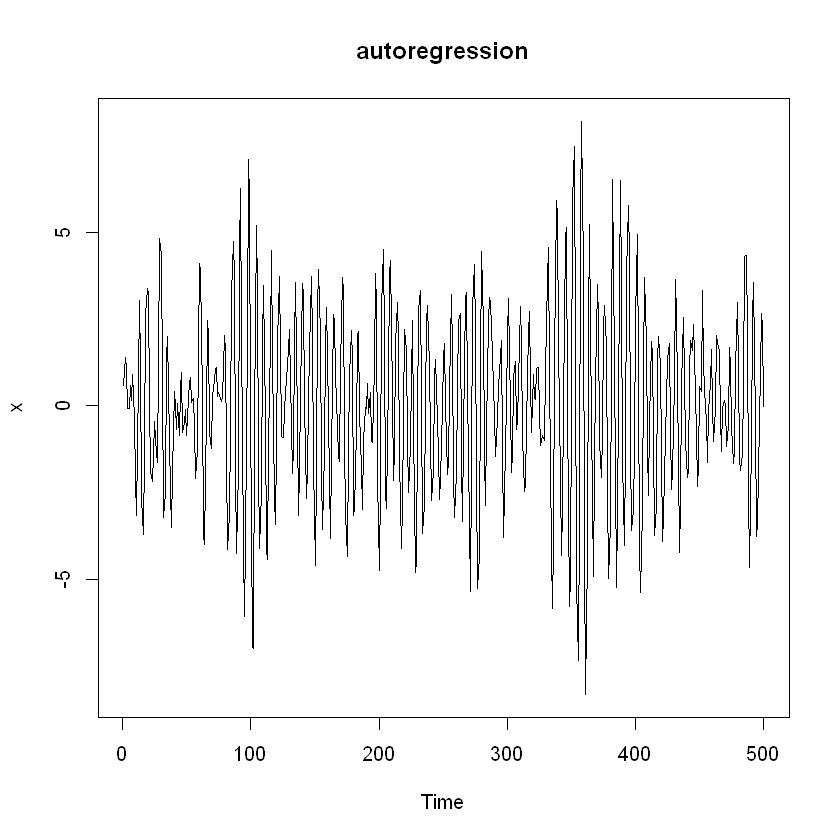

In [58]:
w=rnorm(550,0,1)
x= filter(w, filter=c(1,-.9),method="recursive")[-(1:50)]
plot.ts(x, main="autoregression")

Another simple example. Consider the process
$$y_t = \alpha y_{t-1} + w$$

y variance (measured)  =  4.8528 
y variance (predicted) =  5.060196 


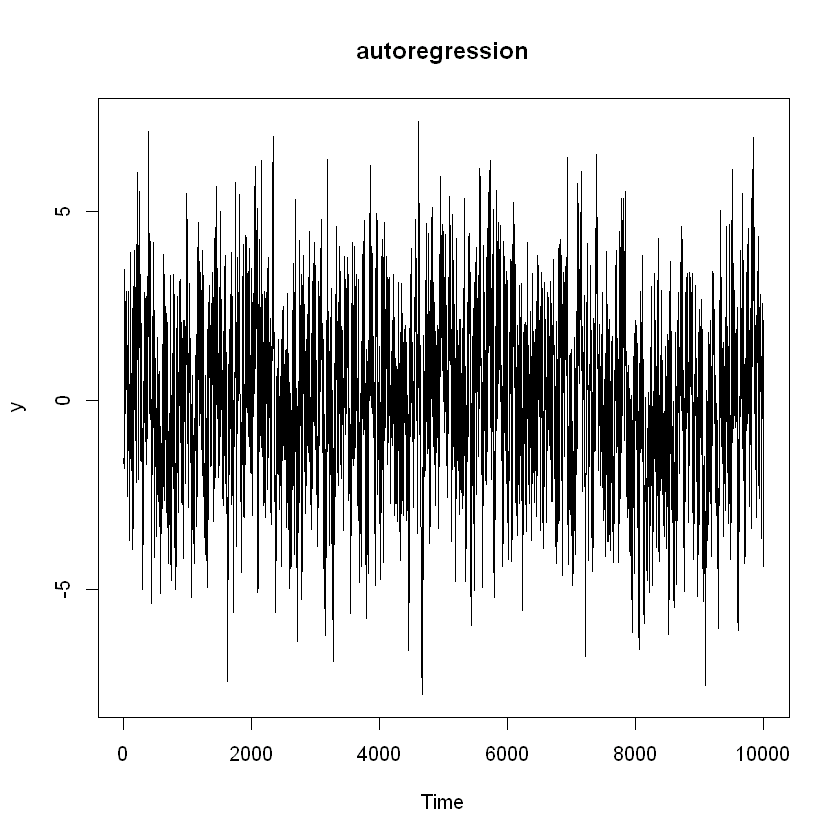

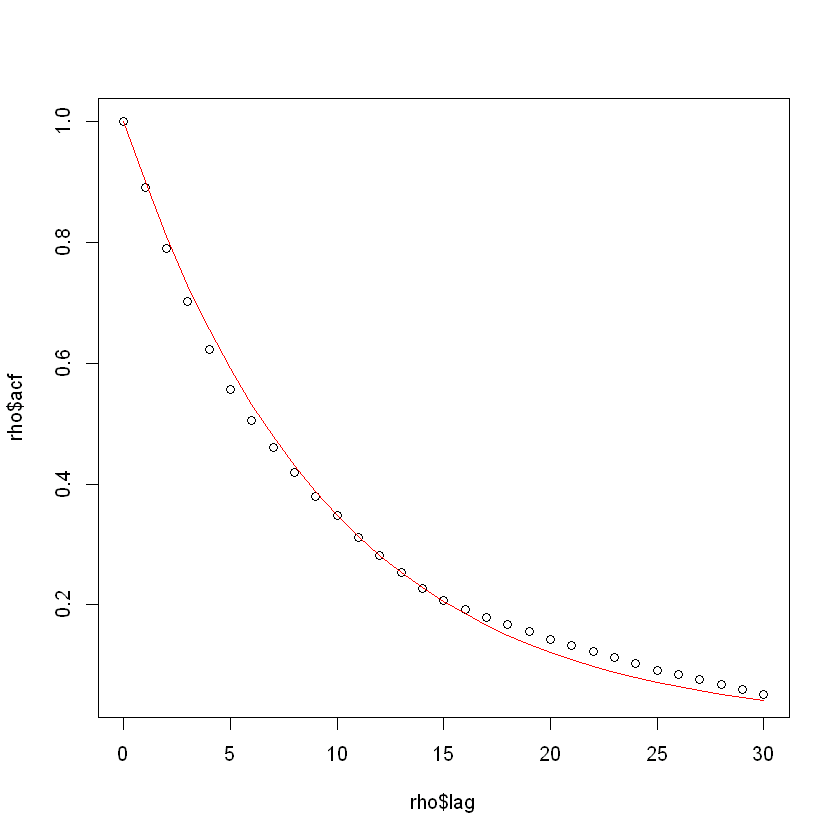

In [59]:
require('stats')
#w     = rnorm(1000)
alpha = .9

#y = filter(w, filter=c(alpha),method="recursive")
y  = arima.sim(model=list(ar=alpha), n=10000)

cat('y variance (measured)  = ',  var(y), "\n")
cat('y variance (predicted) = ', var(w)/(1-alpha*alpha),"\n")

plot.ts(y, main="autoregression")

rho=acf(y, plot=FALSE, lag.max=30)
xx = seq(0,30)
yy = alpha**xx
plot(rho$lag, rho$acf)
lines(xx,yy,col='red')



## Example 1.11 Random walk with drift

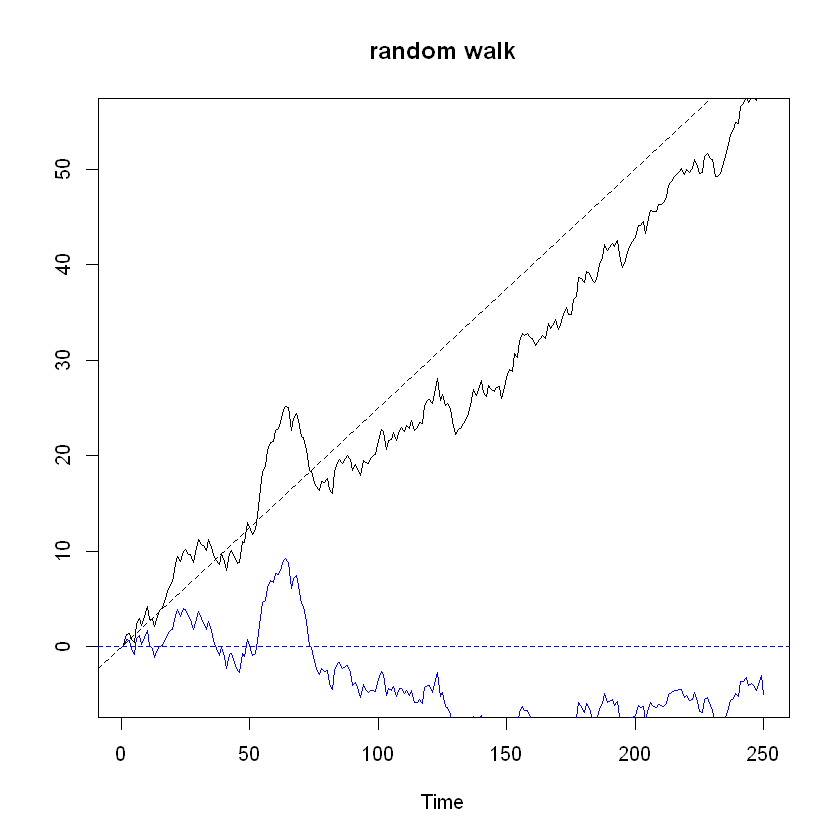

In [60]:
npoints = 250
drift   = .25

w = rnorm(npoints)
x = cumsum(w)

wd = w + drift
xd = cumsum(wd)

plot.ts(xd,ylim=c(-5,55),main="random walk",ylab='')
lines(x,col=4)
abline(h=0, col=4,  lty=2)
abline(a=0, b=drift,lty=2)

## Example 1.12 Signal in Noise

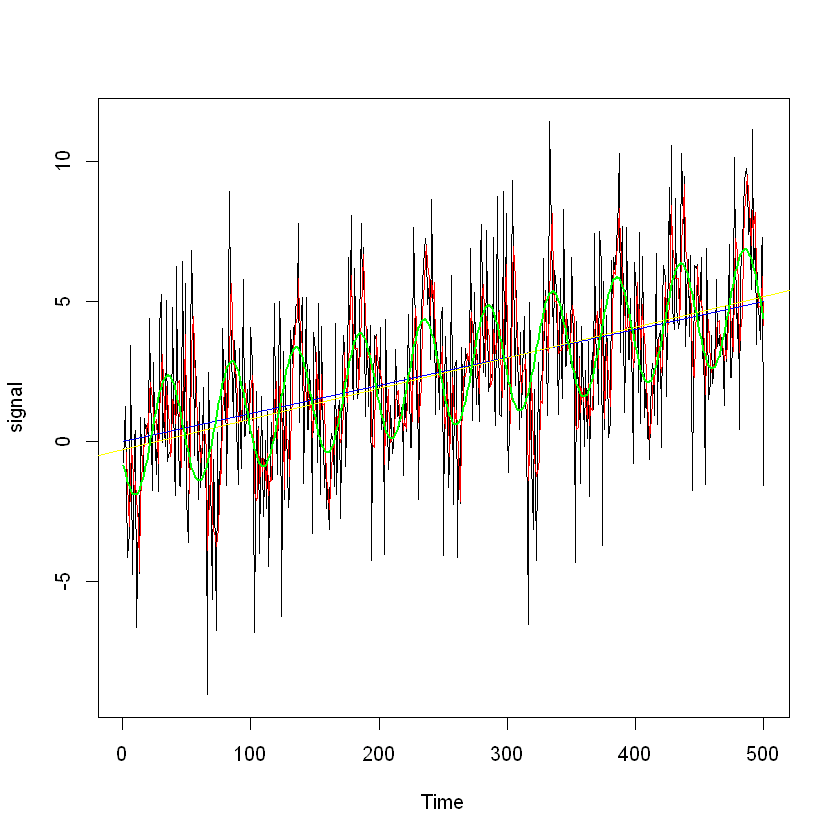

In [61]:
cs     = 2*cos(2*pi*1:500/50+.6*pi)
wd     = 3*w
x      = seq(1:500)
xx     = .01 * x

signal = cs + wd + xx
v=filter(signal,sides=1,filter=rep(1/3,3))

plot.ts(signal)
lines(v,col='red')
lines(xx, col = 'blue')

reg=lm(signal~x)
abline(reg,col="yellow")

lines(cs + xx,col='green',lwd=2)

## 1.6 Estimation of Correlation

In [62]:
set.seed(101010)
x1=2*rbinom(11,1,.5)-1
x2=2*rbinom(10001,1,.5)-1
y1 = 5 + filter(x1, sides=1, filter=c(1,-.7))[-1]
y2 = 5 + filter(x2, sides=1, filter=c(1,-.7))[-1]
#plot.ts(y1, type='s')
#plot.ts(y2, type='s')
acf(y1, lag.max=4,plot=FALSE)
acf(y2, lag.max=4,plot=FALSE)


Autocorrelations of series 'y1', by lag

     0      1      2      3      4 
 1.000 -0.688  0.425 -0.306 -0.007 


Autocorrelations of series 'y2', by lag

     0      1      2      3      4 
 1.000 -0.466 -0.019  0.027 -0.012 